In [94]:
# QuantConnect Imports
%load_ext autoreload
%autoreload 2

from clr import AddReference
AddReference("System")
AddReference('System.Memory')
AddReference("QuantConnect.Algorithm")
AddReference("QuantConnect.Api")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Configuration")
AddReference("QuantConnect.Research")
AddReference("QuantConnect.Indicators")

from System import *
from QuantConnect import *
from QuantConnect.Algorithm import * 
from QuantConnect.Api import *
from QuantConnect.Configuration import *
from QuantConnect.Data import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Research import *
from QuantConnect.Indicators import *

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

# PT imports 
import numpy as np 
import matplotlib.pylab as plt 
from rolling_win import *  # my rolling window , mk_momentum etc. 

# ipython debugger. set breakpoint with `dbg.set_trace()` 
import IPython.core.debugger as dbg

# execute this to connect to QuantConnect API 
api = Api()
api.Initialize(
    Config.GetInt("job-user-id", 94240), 
    Config.Get("api-access-token", "f9683aa5c308894f2238228a5f3545badd2e4b11526685cee58bb1cecf7e9f30"),
    Config.Get("data-folder"))
print(api.Connected)


# Create an quantBook instance
qb = QuantBook()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


In [96]:
# Get the DATA
# load appl into the securities list and get the history of all the added securities 
apl = qb.AddEquity("AAPL")
ggl = qb.AddEquity("GOOGL")
# msft = qb.AddEquity('MSFT')

start_date = datetime(2006,1,1)
end_date = datetime(2012,1,1)

DIM = 21 
DIY = 12*DIM
LOOKBACK = 20*DIY # 20 years

history = qb.History(qb.Securities.Keys, LOOKBACK, Resolution.Daily) 

times = history.index.get_level_values(1)
history = history.loc[(times <= end_date)  & (times > start_date)]
period = np.min(history.groupby(level="symbol").size())

# Computing the momentum 

using the `rolling_win` implementation, computing the momentum, defined by the formula: 

$$ \mu_t = \frac{p_{t-m}-p_{t-y}}{p_{t-y}},$$

is a simple as 
```py 
    rw = MyRollingWin(LOOKBACK)
    rw.batch_update(history)
    # compute the returns now with respect to DIY trading periods ago and shift DIM
    # days back to get the returns 1 month ago now
    momentum = rw.returns(DIY).groupby(level='symbol').shift(-DIM).dropna()
```


where $m$ is the number of trading days in a month (21) and $y$
is the number of trading days in a year ($12\times 21=252$). In
addition, the price changes over the last month can be taken 
into account to temper the expectations for future movement of an asset via the formula 

$$ \mu_t = \left( \frac{p_{t-m}-p_{t-y}}{p_{t-y}} - 
\frac{p_{t-1}-p_{t-m}}{p_{t-m}} \right )/\sigma_{r_t},$$

Notice here that we have normalized by the statistical
estimate of  the volatility in the returns of the asset 
in question, 
$\sigma_{r_t}$, in order to put less weight on highly volatile
securities.



In [139]:
rw = MyRollingWindow( history.groupby(level="symbol").size().min())
rw.batch_update(history)
momentum = mk_momentum(rw,m=1,n=DIY)
winsize = 30
sigma = mk_sigma(rw.data(), window = winsize)
# smoothen a bit the sigmas 
sigma_sma = mk_SMA(sigma.copy(), window = 
                   100)



Text(0, 0.5, 'sigma from 30 ticks')

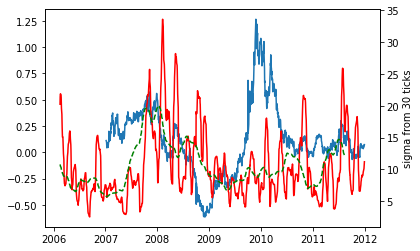

In [140]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
ax2=ax.twinx()
ax.plot(momentum.xs(ggl.Symbol)['close'])
ax2.plot(sigma.xs(ggl.Symbol)['close'], '-r')
ax2.plot(sigma_sma.xs(ggl.Symbol)['close'], '--g')

ax2.set_ylabel("sigma from {} ticks".format(winsize))

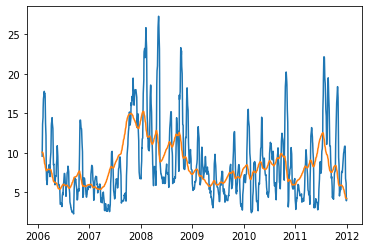

In [134]:
plt.plot(sigma.xs(ggl.Symbol)['close'])
plt.plot(sigma_sma.xs(ggl.Symbol)['close'])

In [81]:
sigma.xs(ggl.Symbol)

,close,high,low,open,volume
time,,,,,
2011-12-31,4.393823,3.971814,4.781145,4.754296,8.366998e+05
2011-12-30,4.872788,4.970866,5.318994,5.291239,8.189923e+05
2011-12-29,6.335129,6.286904,6.537039,6.281300,8.059435e+05
2011-12-28,6.997936,7.167645,7.484691,7.286619,7.929133e+05
2011-12-24,9.096658,8.609427,9.226313,9.148856,8.072758e+05
...,...,...,...,...,...
2006-02-08,15.830432,14.740426,16.365537,14.930800,7.642402e+06
2006-02-07,14.514632,13.609782,15.040443,13.886061,7.655457e+06
2006-02-04,13.375409,12.132051,13.978626,12.519742,7.593294e+06
